In [19]:
import os
import sys
import umap

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from combat.pycombat import pycombat

from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFECV
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, StratifiedGroupKFold, cross_validate
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, chi2, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


from ml.CorrelationFilter import CorrelationFilter
from core.utils.genes import entrez_id_to_gene_symbol

In [20]:
DATA_DIR = '../../db'

In [21]:
db = pd.DataFrame()
dataset_label = pd.Series(name='dataset')
for filename in os.listdir(DATA_DIR):
    if not filename.endswith('.parquet') or filename.endswith('_metadata.parquet'):
        continue

    # read csv
    df = pd.read_parquet(os.path.join(DATA_DIR, filename))

    # append to dfs
    db = pd.concat([db, df])
    tmp = pd.Series([filename[:-8]] * len(df), index=df.index, name='dataset')
    dataset_label = pd.concat([dataset_label, tmp])

db = db.dropna(axis=1)

In [22]:
metadata = pd.DataFrame()
for filename in os.listdir(DATA_DIR):
    if not filename.endswith('_metadata.parquet'):
        continue

    # read csv
    df = pd.read_parquet(os.path.join(DATA_DIR, filename))

    # append to dfs
    metadata = pd.concat([metadata, df])

/usr/local/anaconda3/envs/ibd/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


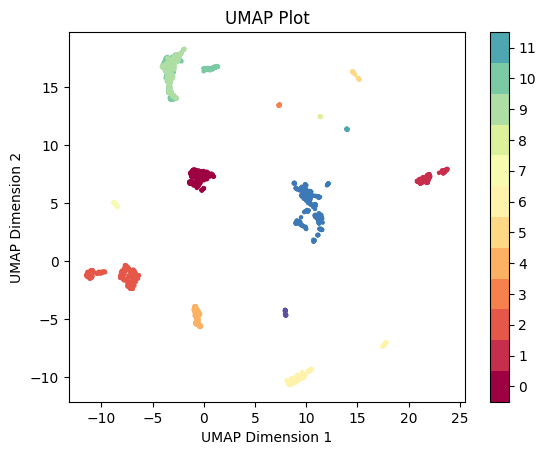

In [23]:
# Create UMAP embedding
umap_embedding = umap.UMAP().fit_transform(db)

# Plot UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(dataset_label).codes, cmap='Spectral', s=5)
plt.title('UMAP Plot')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(boundaries=np.arange(13)-0.5).set_ticks(np.arange(12))
plt.show()

In [24]:
batch = pd.Categorical(dataset_label).codes

data_corrected = pycombat(db.transpose(), batch).transpose()

Found 14 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


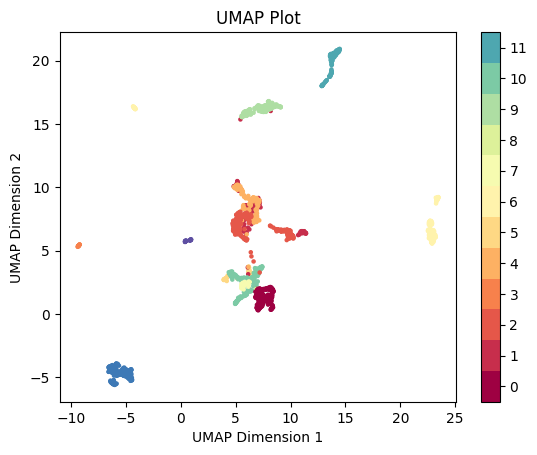

In [25]:
# Create UMAP embedding
umap_embedding = umap.UMAP().fit_transform(data_corrected)

# Plot UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(dataset_label).codes, cmap='Spectral', s=5)
plt.title('UMAP Plot')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(boundaries=np.arange(13)-0.5).set_ticks(np.arange(12))
plt.show()

In [26]:
# Function to normalize datasets individually
def robust_zscore_normalization_per_dataset(df, labels=None):
    if labels is None:
        labels = pd.Series([0] * len(df), index=df.index)

    # Initialize a DataFrame to hold the normalized data
    df_normalized = pd.DataFrame(index=df.index, columns=df.columns)

    # Loop over each unique dataset label and apply RobustScaler individually
    for dataset in labels.unique():
        # Filter the data for the current dataset
        dataset_mask = labels == dataset
        data_subset = df[dataset_mask]

        # Initialize RobustScaler object and fit to the current dataset
        scaler = RobustScaler()
        scaled_subset = scaler.fit_transform(data_subset)

        # Assign the normalized data back to the respective positions in the normalized DataFrame
        df_normalized.loc[dataset_mask] = scaled_subset

    return df_normalized

def quantile_normalization(df):
    # Rank the values within each column (gene), then average the rank scores for each row across all samples
    rank_mean = df.stack().groupby(df.rank(method='average').stack().astype(int)).mean()
    # Assign these averaged rank scores back based on the rank within each gene
    df_normalized = df.rank(method='average').stack().astype(int).map(rank_mean).unstack()
    
    # Ensuring the dataframe maintains the original index and column order
    df_normalized.index = df.index
    df_normalized.columns = df.columns
    
    return df_normalized

In [27]:
db_robust_zscore_normalized = robust_zscore_normalization_per_dataset(db, dataset_label)

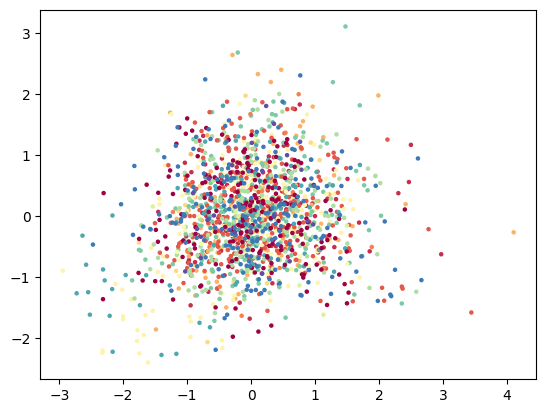

In [32]:
plt.scatter(db_robust_zscore_normalized.iloc[:, -1], db_robust_zscore_normalized.iloc[:, -2], c=pd.Categorical(dataset_label).codes, cmap='Spectral', s=5)
plt.show()

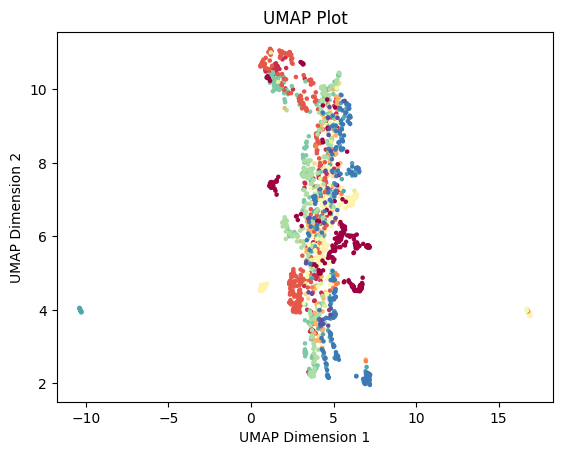

In [29]:
# Create UMAP embedding
umap_embedding = umap.UMAP().fit_transform(db_robust_zscore_normalized)

# Plot UMAP embedding and save to file
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(dataset_label).codes, cmap='Spectral', s=5)
plt.title('UMAP Plot')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.savefig('../../results/umap.png')
plt.show()

## Infliximab response prediction
### Supervised

In [121]:
ifx_datasets = ['GSE73661', 'GSE23597', 'GSE16879', 'GSE52746']
ifx_mask = dataset_label.isin(ifx_datasets)

ifx_metadata = metadata[ifx_mask]
ifx_metadata = ifx_metadata[ifx_metadata.treatment.map(lambda x: not str(x).startswith('vdz'))]
ifx_metadata = pd.concat([ifx_metadata, dataset_label], join='inner', axis=1)

ifx_db = db_robust_zscore_normalized.loc[ifx_metadata.index]

ifx_dataset_label = dataset_label.loc[ifx_metadata.index]

/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_27411/17731204.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ifx_metadata = metadata[ifx_mask]


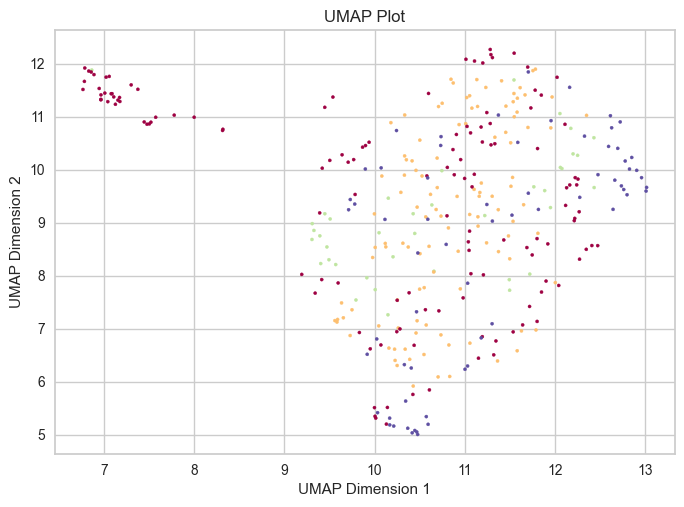

In [122]:
# Create UMAP embedding
umap_embedding = umap.UMAP().fit_transform(ifx_db)

# Plot UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(ifx_dataset_label).codes, cmap='Spectral', s=5)
plt.title('UMAP Plot')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [123]:
# First, we need to check if the patients with no time of biopsy are all control patients
ifx_metadata[ifx_metadata.time_of_biopsy.isna()].disease.value_counts(dropna=False)

disease
Ctrl    41
Name: count, dtype: int64

In [124]:
# Since they are, we can treat all of them as Before biopsy
ifx_metadata.time_of_biopsy = ifx_metadata.time_of_biopsy.fillna('Before')
ifx_metadata.time_of_biopsy.value_counts(dropna=False)

time_of_biopsy
Before    112
After      72
W0         71
W8         36
W30        32
W4_W6      23
W6          3
W14         1
Name: count, dtype: int64

In [125]:
# Now, we can convert the time of biopsy to numeric values
ifx_metadata.time_of_biopsy = ifx_metadata.time_of_biopsy.map(lambda x: 'W5' if x == 'W4_W6' else x)
ifx_metadata.time_of_biopsy.value_counts(dropna=False)

time_of_biopsy
Before    112
After      72
W0         71
W8         36
W30        32
W5         23
W6          3
W14         1
Name: count, dtype: int64

In [126]:
# After that, we can convert the time of biopsy to numeric values
ifx_metadata.time_of_biopsy = ifx_metadata.time_of_biopsy.map(lambda x: 0 if x == 'Before' else (1 if x == 'After' else (int(x[1:] if str(x).startswith('W') else x))))
ifx_metadata.time_of_biopsy.value_counts(dropna=False)

time_of_biopsy
0     183
1      72
8      36
30     32
5      23
6       3
14      1
Name: count, dtype: int64

In [127]:
# Sorting the DataFrame by patient_id and time_of_biopsy to ensure the responses are in the correct order
ifx_metadata_sorted = ifx_metadata.sort_values(by=['dataset', 'patient_id', 'time_of_biopsy'])

# Grouping by patient_id and dataset, then aggregating the responses into a list in the correct biopsy order
patient_responses = ifx_metadata_sorted.groupby(['dataset', 'patient_id']).agg({
    'response': lambda x: list(x)
}).reset_index()

# Convert the aggregated list of responses into a string with a desired separator, e.g., comma, for display
patient_responses['responses_ordered'] = patient_responses['response'].apply(lambda x: ', '.join(map(str, x)))

# Selecting only the columns we want to display
patient_responses_display = patient_responses[['dataset', 'patient_id', 'responses_ordered']]

# Display the DataFrame
# patient_responses_display.to_csv('patient_responses.csv', index=False)

In [128]:
# Convert the DataFrame index (which contains the sample ID) into a column.
ifx_metadata_reset = ifx_metadata.reset_index()
ifx_metadata_reset.rename(columns={'index': 'sample_id'}, inplace=True)

# Sorting the DataFrame by patient_id and time_of_biopsy to ensure the responses are in the correct order.
ifx_metadata_sorted = ifx_metadata_reset.sort_values(by=['dataset', 'patient_id', 'time_of_biopsy'])

# Function to find the first not None response and its sample ID.
def get_first_valid_response(df):
    first_row = df.iloc[0]
    valid_df = df[df['response'].notna()]
    if not valid_df.empty:
        valid_row = valid_df.iloc[0]
    else:
        valid_row = first_row
    return pd.Series({'first_valid_response': valid_row['response'], 'sample_id': first_row['sample_id']})

# Group by patient_id and dataset, apply the function to get the first valid response and its sample_id
first_responses = ifx_metadata_sorted.groupby(['dataset', 'patient_id']).apply(get_first_valid_response).reset_index()

# Display the DataFrame.
first_responses.first_valid_response.value_counts(dropna=False)

first_valid_response
Yes      72
No       68
None     47
Other     3
Name: count, dtype: int64

In [129]:
response = first_responses.set_index('sample_id').first_valid_response
response

sample_id
GSM423033        No
GSM423035        No
GSM423037        No
GSM423039        No
GSM423041        No
              ...  
GSM1900254    Other
GSM1900153     None
GSM1900213      Yes
GSM1900217       No
GSM1900206       No
Name: first_valid_response, Length: 190, dtype: object

In [130]:
X = ifx_db.loc[response.index]
X = X.apply(lambda x: pd.to_numeric(x, errors='coerce'), axis=1).dropna(axis=1)
y = response.rename('response')

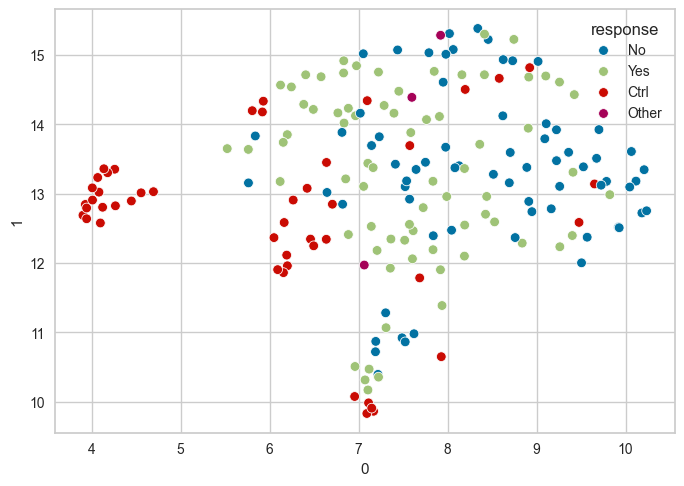

In [131]:
umap_embedding = umap.UMAP().fit_transform(X)

plot_data = pd.concat([pd.DataFrame(umap_embedding, index=X.index), y.fillna('Ctrl').rename('response')], axis=1)

sns.scatterplot(data=plot_data, x=0, y=1, hue="response");

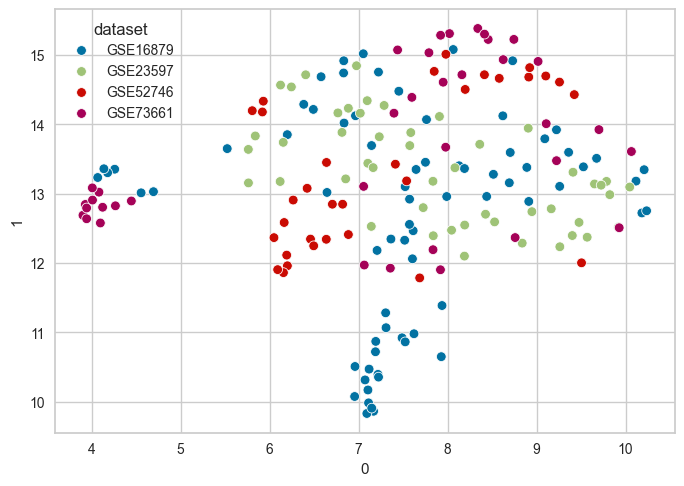

In [132]:
plot_data = pd.concat([pd.DataFrame(umap_embedding, index=X.index), dataset_label], join='inner', axis=1)

sns.scatterplot(data=plot_data, x=0, y=1, hue="dataset");

In [309]:
y = y[(y == 'Yes') | (y == 'No')]
X = X.loc[y.index]
ifx_dataset_label = ifx_dataset_label.loc[y.index]

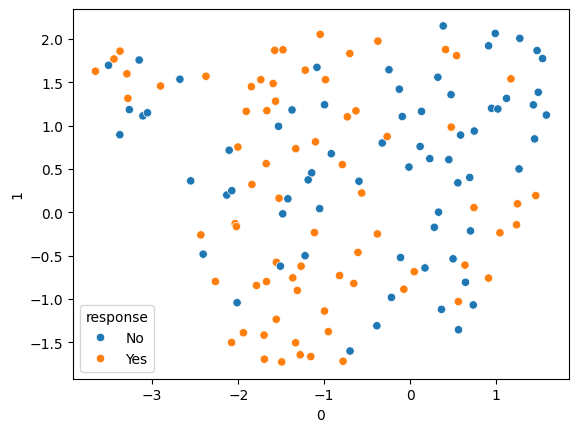

In [24]:
# And now let's just plot the responders and non-responders
umap_embedding = umap.UMAP().fit_transform(X)

plot_data = pd.concat([pd.DataFrame(umap_embedding, index=X.index), y], join='inner', axis=1)

sns.scatterplot(data=plot_data, x=0, y=1, hue="response");

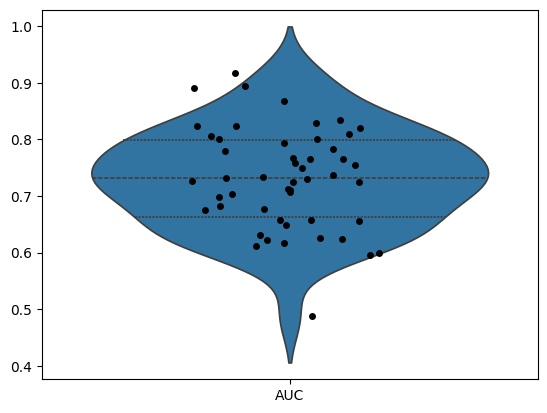

In [25]:
# Now, let's try to predict the response using a Random Forest Classifier and evaluate it in cross-validation using auc
rf = RandomForestClassifier(n_estimators=100, random_state=23)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=23)

cv_results = cross_validate(rf, X, y, cv=cv, scoring='roc_auc', return_estimator=True)

# plot a violinplot of the cross-validation results with seaborn
sns.violinplot(data=pd.DataFrame(cv_results['test_score'], columns=['AUC']), inner='quartile');
sns.stripplot(data=pd.DataFrame(cv_results['test_score'], columns=['AUC']), jitter=0.2, color='black');

In [26]:
cv_results['test_score'].mean()

0.7307807430664574

In [27]:
X.shape

(140, 14306)

In [28]:
# Now let's see how the model performs in grouped cross-validation with groups defined by the name of the dataset
cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=23)

cv_results = cross_validate(rf, X, y, cv=cv, scoring='roc_auc', groups=ifx_dataset_label, return_estimator=True)

cv_results['test_score']

array([0.75919913, 0.7625    , 0.52413793, 0.34285714])

In [29]:
# correlations = X.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()

In [30]:
# plt.plot(correlations.values);

In [31]:
X = entrez_id_to_gene_symbol(X)

22 input query terms found no hit:	['10638', '129790', '149650', '157247', '158295', '158696', '23285', '26148', '283174', '283588', '2


In [96]:
steps = [
    ('variance_threshold', VarianceThreshold()),
    ('scaler', 'passthrough'),
    ('dim_reduction', 'passthrough'),
    ('classifier', 'passthrough')
]

pipeline = Pipeline(steps)

variance_threshold__threshold = [0, 0.05]
scaler__n_bins = [3, 5, 10]
dim_reduction__k = [5, 7, 13, 23, 50, 100, 'all']
classifier__C = [0.01, 0.1, 1, 10, 100]

param_grid = [
    {
        'variance_threshold__threshold': variance_threshold__threshold,
        'scaler': [KBinsDiscretizer(encode='ordinal', strategy='quantile')],
        'scaler__n_bins': scaler__n_bins,
        'dim_reduction': [SelectKBest()],
        'dim_reduction__k': dim_reduction__k,
        'classifier': [GaussianNB()]
    },
    {
        'variance_threshold__threshold': variance_threshold__threshold,
        'scaler': [StandardScaler(), MinMaxScaler(), None],
        'dim_reduction': [SelectKBest()],
        'dim_reduction__k': dim_reduction__k,
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': classifier__C
    },
    {
        'variance_threshold__threshold': variance_threshold__threshold,
        'scaler': [MinMaxScaler()],
        'dim_reduction': [SelectKBest()],
        'dim_reduction__k': dim_reduction__k,
        'classifier': [RandomForestClassifier()]
    }
]

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=23)

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='roc_auc', verbose=1, n_jobs=-1)

y_num = (y == 'Yes').astype(int)

corr_filter = CorrelationFilter(threshold=0.9, cache_file='correlated_pairs.csv')
X_filtered = corr_filter.fit_transform(X)

# results = pd.DataFrame(columns=['train_auc', 'test_auc', 'best_model'])
# for train_index, test_index in tqdm(outer_cv.split(X_filtered, y_num), total=outer_cv.get_n_splits(X_filtered, y_num)):
#     X_train, X_test = X_filtered.iloc[train_index], X_filtered.iloc[test_index]
#     y_train, y_test = y_num.iloc[train_index], y_num.iloc[test_index]

#     model = grid_search.fit(X_train, y_train)
#     y_prob = model.predict_proba(X_test)

#     auc_roc = roc_auc_score(y_test, y_prob[:, 1])
    
#     result = pd.Series({
#         'train_auc': model.best_score_,
#         'test_auc': auc_roc,
#         'best_model': model.best_estimator_
#     })
#     results = pd.concat([results, result.to_frame().T], ignore_index=True)
#     results.to_csv('../../results/results.csv', index=False)

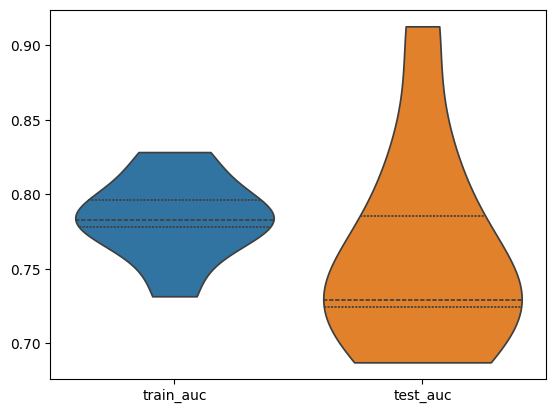

In [36]:
results = pd.read_csv('../../results/20240117_cv_results.csv')

# plot a violinplot of the outer and inner cross-validation results with seaborn
sns.violinplot(data=results[['train_auc', 'test_auc']], inner='quartile', cut=0);

In [37]:
model = grid_search.fit(X, y_num)

Fitting 5 folds for each of 266 candidates, totalling 1330 fits


/usr/local/anaconda3/envs/ibd/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(


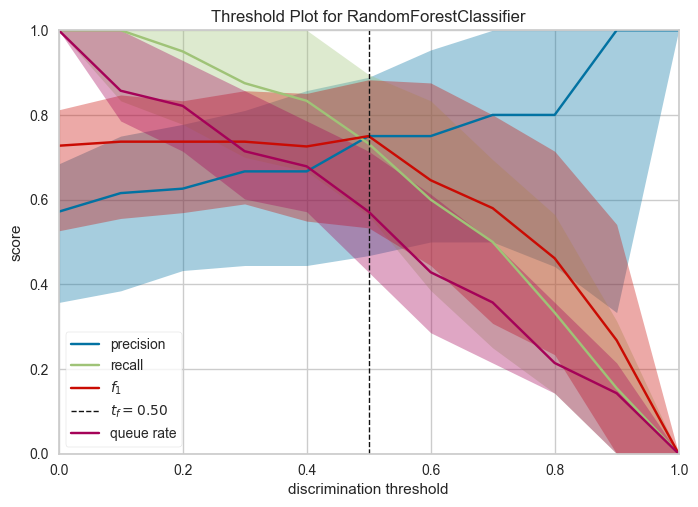

<Axes: title={'center': 'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [67]:
# plot the discrimination threshold from the yellowbrick library
from yellowbrick.classifier import DiscriminationThreshold
viz = DiscriminationThreshold(model.best_estimator_, random_state=23)
viz.fit(X, y_num)
viz.show();

In [38]:
print(model.best_score_)
print(model.best_params_)
print(model.best_estimator_)

0.7730429094714809
{'classifier': RandomForestClassifier(), 'dim_reduction': SelectKBest(), 'dim_reduction__k': 5, 'scaler': MinMaxScaler(), 'variance_threshold__threshold': 0.05}
Pipeline(steps=[('variance_threshold', VarianceThreshold(threshold=0.05)),
                ('scaler', MinMaxScaler()), ('dim_reduction', SelectKBest(k=5)),
                ('classifier', RandomForestClassifier())])


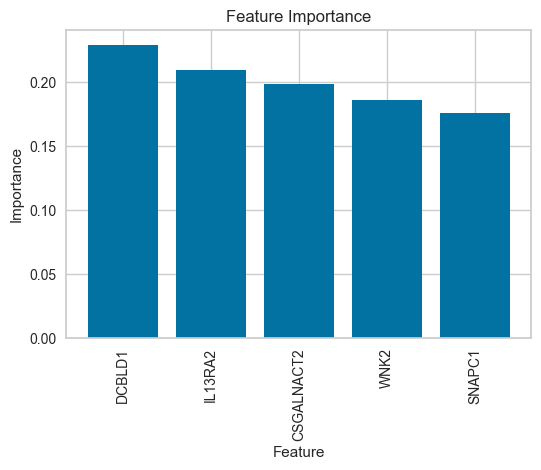

In [75]:
importances = model.best_estimator_['classifier'].feature_importances_
important_features = model.best_estimator_['dim_reduction'].get_support()
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
plt.bar(X.columns[important_features], importances[indices])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [64]:
# save model for later use
import pickle

with open('../../results/20240117_model.pkl', 'wb') as f:
    pickle.dump(model.best_estimator_, f)

In [60]:
ctrl_samples = response[pd.isnull(response)].index
X_ctrl = ifx_db.loc[ctrl_samples]
X_ctrl = entrez_id_to_gene_symbol(X_ctrl)

X_ctrl.shape

22 input query terms found no hit:	['10638', '129790', '149650', '157247', '158295', '158696', '23285', '26148', '283174', '283588', '2


(47, 14284)

In [61]:
y_ctrl_prob = model.best_estimator_.predict_proba(X_ctrl)

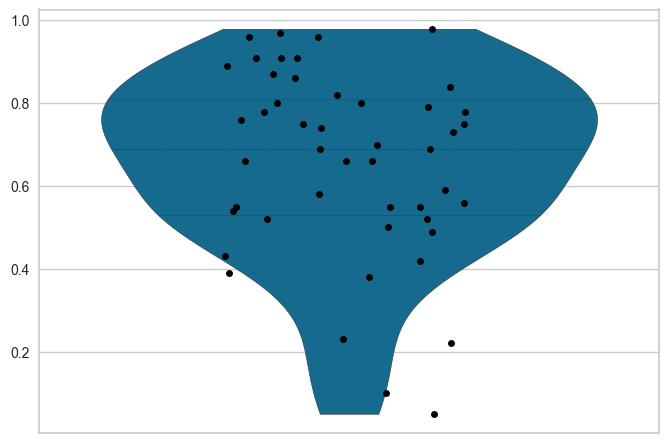

In [68]:
# plot the predicted response probabilities with violinplot and scatterplot
sns.violinplot(data=y_ctrl_prob[:, 1], inner='quartile', cut=0);
sns.stripplot(data=y_ctrl_prob[:, 1], jitter=0.2, color='black');

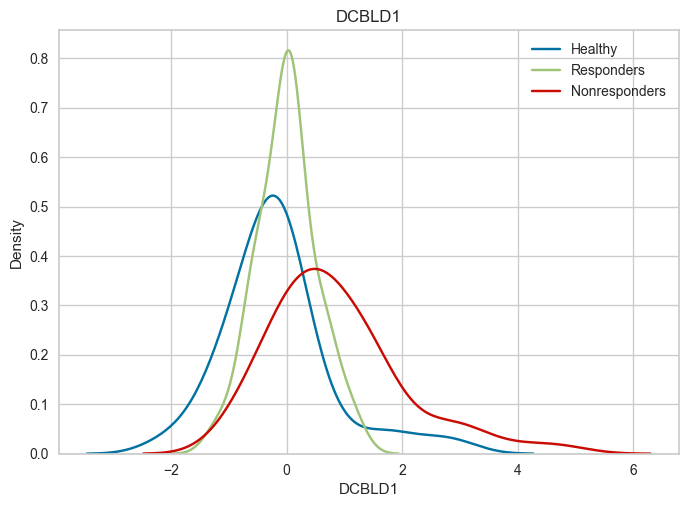

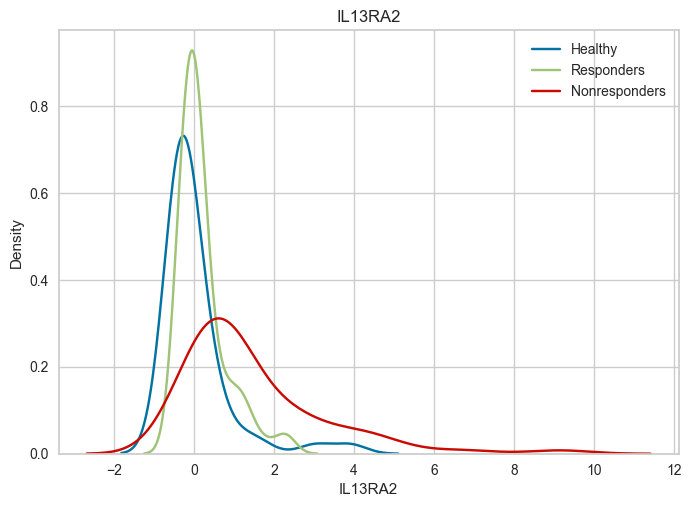

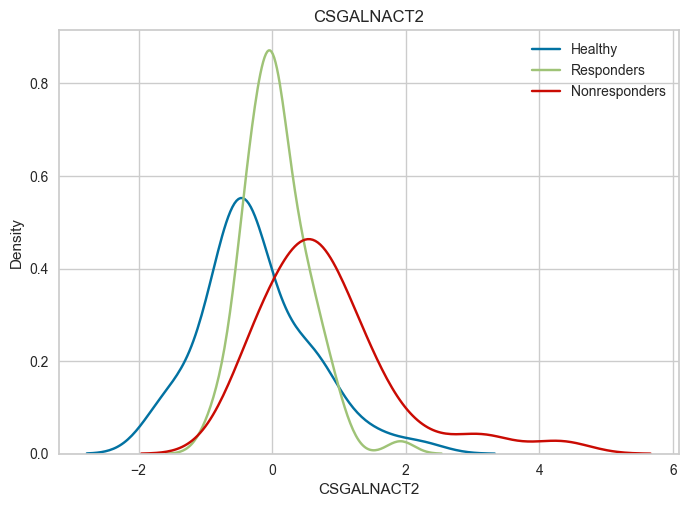

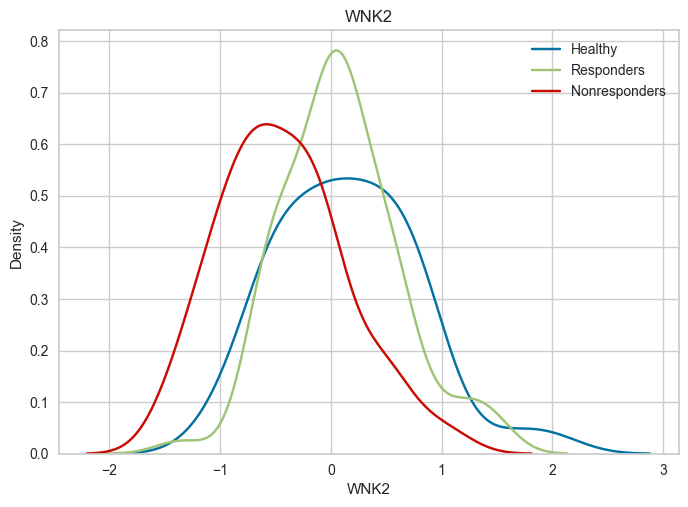

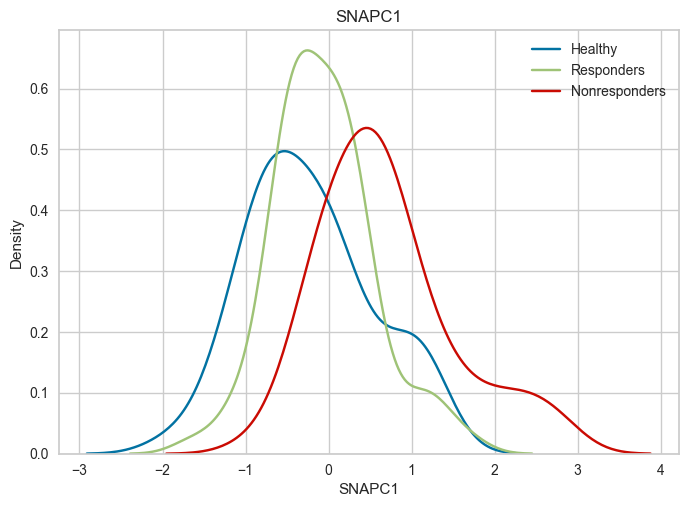

In [90]:
healthy_values = X_ctrl[X_ctrl.columns[model.best_estimator_['dim_reduction'].get_support()]]
ibd_values = X[X.columns[model.best_estimator_['dim_reduction'].get_support()]]

for feature in healthy_values.columns:
    sns.kdeplot(healthy_values[feature], label='Healthy')
    sns.kdeplot(ibd_values[y == 'Yes'][feature], label='Responders')
    sns.kdeplot(ibd_values[y == 'No'][feature], label='Nonresponders')
    plt.title(feature)
    plt.legend()
    plt.show()

In [ ]:
correlations = pd.read_csv('correlated_pairs.csv')

In [115]:
gene_names = X.columns[model.best_estimator_['dim_reduction'].get_support()]

for gene_name in gene_names:
    print(gene_name)
    high_correlations = correlations[((correlations['Feature 2'] == gene_name) | (correlations['Feature 1'] == gene_name)) & (correlations.Correlation > 0.8)]

    print(pd.concat([high_correlations['Feature 1'], high_correlations['Feature 2']]).unique())


DCBLD1
[]
IL13RA2
[]
CSGALNACT2
['GLIPR1' 'RAB31' 'RASSF8' 'COL7A1' 'ELK3' 'FGF7' 'SAMD4A' 'SRGAP2' 'LY96'
 'HGF' 'IL1R1' 'LOX' 'MMP19' 'MYO5A' 'NRCAM' 'PRR16' 'CHST15' 'SGTB'
 'CSGALNACT2' 'RBMS1' 'CLMP' 'RUNX2' 'QKI' 'HS3ST3B1']
WNK2
[]
SNAPC1
[]


In [167]:
# Now, let's build a model to see what differentiates patients patients with IBD from healthy controls
X = ifx_db.loc[response.index]
X = X.apply(lambda x: pd.to_numeric(x, errors='coerce'), axis=1).dropna(axis=1)
y = response.rename('response')

y_healthy = (pd.isnull(y)).astype(int)
X_healthy = X.loc[y_healthy.index]
X_healthy = entrez_id_to_gene_symbol(X_healthy)

22 input query terms found no hit:	['10638', '129790', '149650', '157247', '158295', '158696', '23285', '26148', '283174', '283588', '2


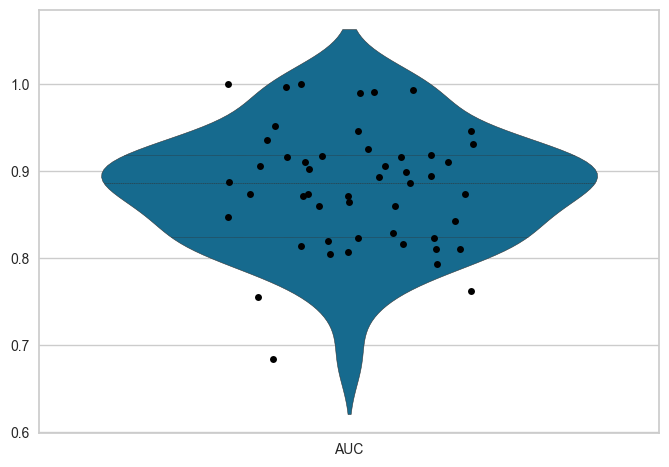

In [174]:
# model_healthy = model.best_estimator_
model_healthy = RandomForestClassifier(random_state=23, class_weight='balanced')

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=23)

cv_results = cross_validate(model_healthy, X_healthy, y_healthy, cv=cv, scoring='roc_auc', return_estimator=True)

# plot a violinplot of the cross-validation results with seaborn
sns.violinplot(data=pd.DataFrame(cv_results['test_score'], columns=['AUC']), inner='quartile');
sns.stripplot(data=pd.DataFrame(cv_results['test_score'], columns=['AUC']), jitter=0.2, color='black');

model_healthy = model_healthy.fit(X_healthy, y_healthy)

In [177]:
X_healthy.columns[model_healthy.feature_importances_.argsort()[::-1].tolist()][:20]

Index(['OAS2', 'ZNFX1', 'SEC14L1', 'ASPHD2', 'MMP7', 'PLAU', 'MATN2', 'CASP1',
       'LPCAT1', 'HSP90B1', 'IL15RA', 'DUOX2', 'PDZK1IP1', 'ACP3', 'CD80',
       'BACE2', 'JAK2', 'CYTIP', 'SNX24', 'C15orf40'],
      dtype='object', name='ENTREZ_ID')

## Semi-supervised model

In [266]:
db_robust_zscore_normalized

ENTREZ_ID,A1BG,NAT2,ADA,CDH2,AKT3,MED6,NR2E3,NAALAD2,ACOT8,ABI1,...,REC8,HNRNPDL,DMTF1,PPP4R1,CDH1,PTBP3,KCNE2,DGCR2,CASP8AP2,SCO2
index,,,,,,,,,,,,,,,,,,,,,
GSM901319,0.123432,0.054647,-0.298714,-0.481411,0.727847,0.340393,0.09959,2.236778,-0.246692,-0.003275,...,-1.166849,0.571298,0.626953,0.114741,-0.089993,-0.792855,-0.725339,-0.14123,0.294283,-0.664037
GSM901320,0.61303,0.021071,-0.08957,0.54965,0.127827,-0.282516,0.272721,0.922575,0.103464,0.223096,...,-0.600939,0.246093,0.070039,-0.57715,0.298772,-0.510938,0.129916,0.088758,-0.050954,-1.137633
GSM901321,-1.141547,0.0,-0.452153,-0.641369,0.056901,-0.158517,0.963375,0.351442,0.28246,0.0,...,-0.628489,0.0,-0.203104,-0.271784,0.357216,0.093799,0.0,0.118522,1.616597,0.268819
GSM901322,0.17661,0.278384,-0.080356,0.0,-0.020045,-0.579299,1.591496,0.3751,0.425921,-0.330595,...,0.439811,-0.119441,0.794071,-1.425342,0.17279,0.582308,0.847452,0.506925,0.0,-0.123586
GSM901323,-0.314235,0.013087,-0.274426,0.048791,0.15262,0.361785,0.172004,2.382433,-0.212475,0.211625,...,-0.66471,0.820311,0.508291,0.313419,0.346775,0.0,-0.003827,0.181127,1.663348,-1.0311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM240027,-0.163636,0.634761,-0.926158,0.47619,-0.915698,-0.983713,1.333333,0.0,0.646465,0.352113,...,-0.353846,-0.30663,-0.158416,0.883721,0.344234,-0.160121,0.896552,0.834862,0.308725,-0.295918
GSM240028,2.090909,-0.372796,0.801001,3.952381,0.909884,-1.087948,-0.333333,0.813008,-0.888889,-2.915493,...,1.276923,0.361878,0.158416,0.015504,-0.7642,-1.954683,-0.206897,-0.688073,-1.865772,-0.785714
GSM240029,-0.127273,0.604534,-0.650814,-3.190476,-0.031977,0.631922,0.238095,0.520325,0.694949,-0.43662,...,-1.246154,0.516575,-0.237624,0.015504,0.447504,0.47432,0.068966,1.0,2.107383,0.561224


In [268]:
# X_semi = entrez_id_to_gene_symbol(db_robust_zscore_normalized)
X_semi = db_robust_zscore_normalized

In [269]:
X_semi = X_semi[-ifx_mask]
metadata_semi = metadata[-ifx_mask]
metadata_semi['patient_id'] = metadata_semi['patient_id'].astype(str)
metadata_semi = pd.concat([metadata_semi, dataset_label], join='inner', axis=1)

/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_27411/3932232485.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metadata_semi = metadata[-ifx_mask]
/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_27411/3932232485.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_semi['patient_id'] = metadata_semi['patient_id'].astype(str)


In [270]:
# Show datasets with multiple samples from the same patient
metadata_semi[metadata_semi.duplicated(keep=False)].sort_values(by=['dataset', 'patient_id']).dataset.unique()

array(['GSE11223', 'GSE9452'], dtype=object)

In [273]:
# It turns out the duplicated samples coming from the same patient are taken from different locations in the gut and states of inflammation.
# For now, we'll just take all samples into account, but we'll need to take this into account later by extracting this information from metadata.

# First, let's just see how would the patients respond to IFX according to our model.
y_prob = model.best_estimator_.predict_proba(X_semi)[:, 1]

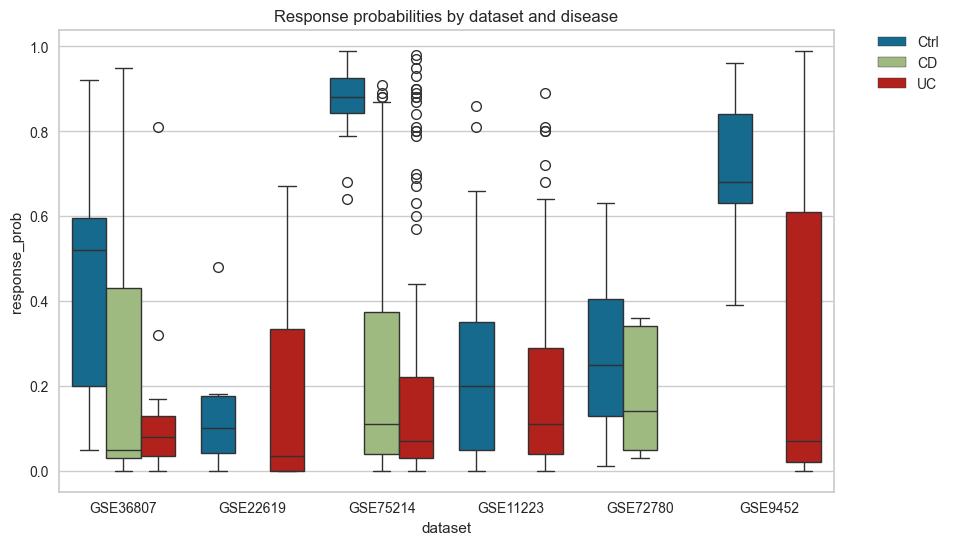

In [302]:
response_prob = pd.Series(y_prob, index=X_semi.index, name='response_prob') 
plot_data = pd.concat([metadata_semi, response_prob], join='inner', axis=1)

plt.figure(figsize=(10, 6))
sns.boxplot(plot_data, x='dataset', y='response_prob', hue='disease');
plt.title('Response probabilities by dataset and disease');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [303]:
metadata_semi.disease.value_counts(dropna=False)

disease
UC      272
Ctrl    121
CD       93
Name: count, dtype: int64

In [316]:
from sklearn.semi_supervised import SelfTrainingClassifier

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=23)

results = pd.DataFrame()

for train_index, test_index in tqdm(cv.split(X, y_num), total=cv.get_n_splits(X, y_num)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_num.iloc[train_index], y_num.iloc[test_index]

    supervised_model = model.best_estimator_.fit(X_train, y_train)
    supervised_y_prob = supervised_model.predict_proba(X_test)
    supervised_auc_roc = roc_auc_score(y_test, supervised_y_prob[:, 1])


    X_combined = pd.concat([X_train, X_semi])
    y_semi_supervised = pd.concat([y_train, pd.Series([-1] * X_semi.shape[0])])

    semi_supervised_clf = SelfTrainingClassifier(model.best_estimator_, threshold=0.95)
    semi_supervised_clf.fit(X_combined, y_semi_supervised)
    semi_supervised_y_prob = semi_supervised_clf.predict_proba(X_test)
    semi_supervised_auc_roc = roc_auc_score(y_test, semi_supervised_y_prob[:, 1])

    result = pd.Series({
        'supervised_auc': supervised_auc_roc,
        'semi_supervised_auc': semi_supervised_auc_roc
    })

    results = pd.concat([results, result.to_frame().T], ignore_index=True)

    results.to_csv('../../results/20240120_semi_supervised_results.csv', index=False)

  0%|          | 0/20 [00:00<?, ?it/s]

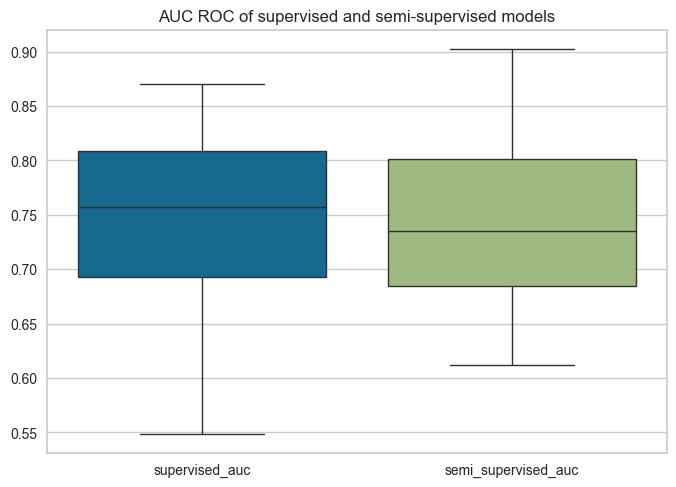

In [318]:
results = pd.read_csv('../../results/20240120_semi_supervised_results.csv')
sns.boxplot(data=results);
plt.title('AUC ROC of supervised and semi-supervised models');